In [ ]:
!pip install awscli

In [ ]:
!aws configure

In [5]:
!mkdir -p datasets/

In [6]:
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz datasets/

download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz


In [8]:
!mkdir 3band 8band geojson

In [13]:
!rm -rf datasets/3band
!rm -rf datasets/8band
!rm -rf datasets/geojson

In [ ]:
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz -C datasets/

In [7]:
import os
from os.path import join

In [3]:
image_3b = "datasets/3band"
image_8b = "datasets/8band"
geojson = "datasets/geojson"
print(len([name for name in os.listdir(image_3b)]), "3b images")
print(len([name for name in os.listdir(image_8b)]), "8b images")
print(len([name for name in os.listdir(geojson)]), "geojson labels")

6940 3b images
6940 8b images
6940 geojson labels


In [14]:
!pip install rasterio

ERROR: Could not find a version that satisfies the requirement geopanda (from versions: none)
ERROR: No matching distribution found for geopanda


In [8]:
import importlib
import RioDataset
import create_data_loaders
import split_dataset
importlib.reload(RioDataset)
importlib.reload(create_data_loaders)
importlib.reload(split_dataset)

ModuleNotFoundError: No module named 'geopandas'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from create_data_loaders import create_data_loaders
from split_dataset import split_dataset

C:\Users\binh.np\AppData\Local\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


ModuleNotFoundError: No module named 'torchvision'

In [12]:
import importlib
import split_dataset
importlib.reload(split_dataset)

ModuleNotFoundError: No module named 'split_dataset'

In [9]:
from preprocess.SplitDataset import SplitDataset

target_dir = "/train/"
os.makedirs(target_dir, exist_ok=True)
SplitDataset(
    data_dir="/datasets",
    target_dir=target_dir
)

NameError: name 'split_dataset' is not defined

In [38]:
print(len([name for name in os.listdir(target_dir + "train/3band")]), "Train")
print(len([name for name in os.listdir(target_dir + "train/8band")]), "Valid")
print(len([name for name in os.listdir(target_dir + "train/geojson")]), "Test")

5899 Train
5899 Valid
5899 Test


In [ ]:
from create_data_loaders import create_data_loaders
train_loader, val_loader, test_loader = create_data_loaders(target_dir, batch_size=32, num_workers=4)
print(train_loader)
print(val_loader)
print(test_loader)

Found 4858 valid image-mask pairs
Found 1041 valid image-mask pairs
Found 1041 valid image-mask pairs


In [ ]:
# Initialize model
from models.unet.model import UNet
model = UNet(num_classes=1, in_channels=3)  # Adjust in_channels based on your .tiff files
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model = model.to(device)

Using device:  cuda


In [ ]:
from DiceBCELoss import DiceBCELoss
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [ ]:
start_epoch = 0
checkpoint_path = "checkpoint.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # resume from next epoch
    print(f"[✓] Loaded checkpoint from epoch {start_epoch}")
else:
    print("[INFO] No checkpoint found. Training from scratch.")

[INFO] No checkpoint found. Training from scratch.


In [ ]:
from tqdm import tqdm

# Trainig Loop
num_epochs = 100
for epoch in range(start_epoch, num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.sigmoid(outputs) > 0.5
        acc = (pred == masks).float().mean()

        train_loss += loss.item()
        train_acc += acc.item()

        loop.set_postfix({
            "loss": loss.item(),
            "acc": acc.item()
        })

    # Validation phase
    model.eval()
    val_loss = 0
    dice_score = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate Dice coefficient
            pred = torch.sigmoid(outputs) > 0.5
            dice_score += (2 * (pred * masks).sum()) / ((pred + masks).sum() + 1e-8)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Dice: {dice_score/len(val_loader):.4f}')

    # Update learning rate based on validation losp
    scheduler.step(val_loss)

Epoch 1/100: 100%|██████████| 152/152 [01:17<00:00,  1.95it/s, loss=0.67, acc=0.916]


Epoch 1/100, Train Loss: 1.1066, Val Loss: 0.8265, Dice: 0.4487


Epoch 2/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.628, acc=0.922]


Epoch 2/100, Train Loss: 0.6663, Val Loss: 0.6309, Dice: 0.5898


Epoch 3/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.492, acc=0.95]


Epoch 3/100, Train Loss: 0.6000, Val Loss: 0.6017, Dice: 0.6114


Epoch 4/100: 100%|██████████| 152/152 [01:17<00:00,  1.97it/s, loss=0.548, acc=0.927]


Epoch 4/100, Train Loss: 0.5810, Val Loss: 0.5561, Dice: 0.6491


Epoch 5/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.555, acc=0.913]


Epoch 5/100, Train Loss: 0.5461, Val Loss: 0.5779, Dice: 0.6196


Epoch 6/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=1.08, acc=0.786]


Epoch 6/100, Train Loss: 0.7202, Val Loss: 0.9303, Dice: 0.2948


Epoch 7/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.772, acc=0.914]


Epoch 7/100, Train Loss: 1.3930, Val Loss: 0.8087, Dice: 0.4682


Epoch 8/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.64, acc=0.912]


Epoch 8/100, Train Loss: 0.7120, Val Loss: 0.7777, Dice: 0.4751


Epoch 9/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.623, acc=0.916]


Epoch 9/100, Train Loss: 0.6512, Val Loss: 0.6274, Dice: 0.5968


Epoch 10/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.569, acc=0.922]


Epoch 10/100, Train Loss: 0.6238, Val Loss: 0.6042, Dice: 0.6132


Epoch 11/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.601, acc=0.911]


Epoch 11/100, Train Loss: 0.5938, Val Loss: 0.6029, Dice: 0.6097


Epoch 12/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.541, acc=0.94]


Epoch 12/100, Train Loss: 0.5885, Val Loss: 0.6213, Dice: 0.5922


Epoch 13/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.576, acc=0.921]


Epoch 13/100, Train Loss: 0.5807, Val Loss: 0.6113, Dice: 0.6197


Epoch 14/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.615, acc=0.907]


Epoch 14/100, Train Loss: 0.5700, Val Loss: 0.5777, Dice: 0.6290


Epoch 15/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.476, acc=0.945]


Epoch 15/100, Train Loss: 0.5607, Val Loss: 0.5791, Dice: 0.6231


Epoch 16/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.566, acc=0.936]


Epoch 16/100, Train Loss: 0.5513, Val Loss: 0.5593, Dice: 0.6426


Epoch 17/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.564, acc=0.942]


Epoch 17/100, Train Loss: 0.5425, Val Loss: 0.5596, Dice: 0.6414


Epoch 18/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.46, acc=0.95]


Epoch 18/100, Train Loss: 0.5403, Val Loss: 0.5583, Dice: 0.6384


Epoch 19/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.535, acc=0.92]


Epoch 19/100, Train Loss: 0.5353, Val Loss: 0.5469, Dice: 0.6479


Epoch 20/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.517, acc=0.921]


Epoch 20/100, Train Loss: 0.5272, Val Loss: 0.5590, Dice: 0.6356


Epoch 21/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.537, acc=0.932]


Epoch 21/100, Train Loss: 0.5283, Val Loss: 0.5427, Dice: 0.6521


Epoch 22/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.545, acc=0.931]


Epoch 22/100, Train Loss: 0.5243, Val Loss: 0.5404, Dice: 0.6519


Epoch 23/100: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s, loss=0.535, acc=0.913]


Epoch 23/100, Train Loss: 0.5176, Val Loss: 0.5308, Dice: 0.6580


Epoch 24/100: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s, loss=0.519, acc=0.938]


Epoch 24/100, Train Loss: 0.5179, Val Loss: 0.5303, Dice: 0.6612


Epoch 25/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.479, acc=0.928]


Epoch 25/100, Train Loss: 0.5135, Val Loss: 0.5244, Dice: 0.6644


Epoch 26/100: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s, loss=0.545, acc=0.932]


Epoch 26/100, Train Loss: 0.5104, Val Loss: 0.5312, Dice: 0.6600


Epoch 27/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.488, acc=0.925]


Epoch 27/100, Train Loss: 0.5095, Val Loss: 0.5392, Dice: 0.6497


Epoch 28/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.426, acc=0.959]


Epoch 28/100, Train Loss: 0.5056, Val Loss: 0.5401, Dice: 0.6599


Epoch 29/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.455, acc=0.948]


Epoch 29/100, Train Loss: 0.5036, Val Loss: 0.5156, Dice: 0.6729


Epoch 30/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.5, acc=0.929]


Epoch 30/100, Train Loss: 0.5010, Val Loss: 0.5192, Dice: 0.6663


Epoch 31/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.561, acc=0.922]


Epoch 31/100, Train Loss: 0.4979, Val Loss: 0.5184, Dice: 0.6693


Epoch 32/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.485, acc=0.933]


Epoch 32/100, Train Loss: 0.4966, Val Loss: 0.5079, Dice: 0.6773


Epoch 33/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.455, acc=0.95]


Epoch 33/100, Train Loss: 0.4950, Val Loss: 0.5174, Dice: 0.6678


Epoch 34/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.506, acc=0.923]


Epoch 34/100, Train Loss: 0.4929, Val Loss: 0.5182, Dice: 0.6651


Epoch 35/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.45, acc=0.938]


Epoch 35/100, Train Loss: 0.4903, Val Loss: 0.5062, Dice: 0.6760


Epoch 36/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.511, acc=0.936]


Epoch 36/100, Train Loss: 0.4892, Val Loss: 0.5011, Dice: 0.6803


Epoch 37/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.476, acc=0.947]


Epoch 37/100, Train Loss: 0.4910, Val Loss: 0.5046, Dice: 0.6778


Epoch 38/100: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s, loss=0.482, acc=0.936]


Epoch 38/100, Train Loss: 0.4872, Val Loss: 0.4991, Dice: 0.6828


Epoch 39/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.438, acc=0.962]


Epoch 39/100, Train Loss: 0.4862, Val Loss: 0.5097, Dice: 0.6768


Epoch 40/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.507, acc=0.935]


Epoch 40/100, Train Loss: 0.4826, Val Loss: 0.4990, Dice: 0.6822


Epoch 41/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.491, acc=0.958]


Epoch 41/100, Train Loss: 0.4820, Val Loss: 0.4983, Dice: 0.6848


Epoch 42/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.503, acc=0.92]


Epoch 42/100, Train Loss: 0.4835, Val Loss: 0.5068, Dice: 0.6736


Epoch 43/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.394, acc=0.963]


Epoch 43/100, Train Loss: 0.4802, Val Loss: 0.4984, Dice: 0.6823


Epoch 44/100: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s, loss=0.457, acc=0.938]


Epoch 44/100, Train Loss: 0.4823, Val Loss: 0.4966, Dice: 0.6832


Epoch 45/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.451, acc=0.947]


Epoch 45/100, Train Loss: 0.4756, Val Loss: 0.5004, Dice: 0.6782


Epoch 46/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.452, acc=0.941]


Epoch 46/100, Train Loss: 0.4746, Val Loss: 0.4932, Dice: 0.6867


Epoch 47/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.502, acc=0.93]


Epoch 47/100, Train Loss: 0.4751, Val Loss: 0.5076, Dice: 0.6700


Epoch 48/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.451, acc=0.936]


Epoch 48/100, Train Loss: 0.4753, Val Loss: 0.4927, Dice: 0.6863


Epoch 49/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.517, acc=0.91]


Epoch 49/100, Train Loss: 0.4744, Val Loss: 0.4940, Dice: 0.6832


Epoch 50/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.502, acc=0.927]


Epoch 50/100, Train Loss: 0.4720, Val Loss: 0.4919, Dice: 0.6889


Epoch 51/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.447, acc=0.933]


Epoch 51/100, Train Loss: 0.4718, Val Loss: 0.4985, Dice: 0.6868


Epoch 52/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.446, acc=0.947]


Epoch 52/100, Train Loss: 0.4716, Val Loss: 0.4896, Dice: 0.6873


Epoch 53/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.438, acc=0.93]


Epoch 53/100, Train Loss: 0.4712, Val Loss: 0.4922, Dice: 0.6880


Epoch 54/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.457, acc=0.937]


Epoch 54/100, Train Loss: 0.4680, Val Loss: 0.4921, Dice: 0.6850


Epoch 55/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.464, acc=0.943]


Epoch 55/100, Train Loss: 0.4653, Val Loss: 0.4864, Dice: 0.6904


Epoch 56/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.444, acc=0.945]


Epoch 56/100, Train Loss: 0.4668, Val Loss: 0.4910, Dice: 0.6859


Epoch 57/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.462, acc=0.954]


Epoch 57/100, Train Loss: 0.4658, Val Loss: 0.4852, Dice: 0.6893


Epoch 58/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.467, acc=0.941]


Epoch 58/100, Train Loss: 0.4622, Val Loss: 0.4895, Dice: 0.6861


Epoch 59/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.49, acc=0.919]


Epoch 59/100, Train Loss: 0.4607, Val Loss: 0.4896, Dice: 0.6891


Epoch 60/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.45, acc=0.946]


Epoch 60/100, Train Loss: 0.4646, Val Loss: 0.4856, Dice: 0.6899


Epoch 61/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.488, acc=0.937]


Epoch 61/100, Train Loss: 0.4629, Val Loss: 0.4938, Dice: 0.6824


Epoch 62/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.474, acc=0.938]


Epoch 62/100, Train Loss: 0.4621, Val Loss: 0.4883, Dice: 0.6874


Epoch 63/100: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s, loss=0.492, acc=0.933]


Epoch 63/100, Train Loss: 0.4629, Val Loss: 0.4880, Dice: 0.6886


Epoch 64/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.5, acc=0.915]


Epoch 64/100, Train Loss: 0.4550, Val Loss: 0.4821, Dice: 0.6913


Epoch 65/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.411, acc=0.947]


Epoch 65/100, Train Loss: 0.4513, Val Loss: 0.4757, Dice: 0.6963


Epoch 66/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.411, acc=0.95]


Epoch 66/100, Train Loss: 0.4511, Val Loss: 0.4775, Dice: 0.6964


Epoch 67/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.415, acc=0.959]


Epoch 67/100, Train Loss: 0.4527, Val Loss: 0.4803, Dice: 0.6940


Epoch 68/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.438, acc=0.94]


Epoch 68/100, Train Loss: 0.4518, Val Loss: 0.4848, Dice: 0.6895


Epoch 69/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.407, acc=0.957]


Epoch 69/100, Train Loss: 0.4508, Val Loss: 0.4734, Dice: 0.6971


Epoch 70/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.51, acc=0.915]


Epoch 70/100, Train Loss: 0.4495, Val Loss: 0.4916, Dice: 0.6839


Epoch 71/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.453, acc=0.951]


Epoch 71/100, Train Loss: 0.4493, Val Loss: 0.4707, Dice: 0.6999


Epoch 72/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.481, acc=0.94]


Epoch 72/100, Train Loss: 0.4483, Val Loss: 0.4852, Dice: 0.6878


Epoch 73/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.516, acc=0.913]


Epoch 73/100, Train Loss: 0.4478, Val Loss: 0.4746, Dice: 0.6988


Epoch 74/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.445, acc=0.949]


Epoch 74/100, Train Loss: 0.4487, Val Loss: 0.4769, Dice: 0.6942


Epoch 75/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.42, acc=0.945]


Epoch 75/100, Train Loss: 0.4512, Val Loss: 0.4776, Dice: 0.6964


Epoch 76/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.44, acc=0.957]


Epoch 76/100, Train Loss: 0.4482, Val Loss: 0.4740, Dice: 0.6958


Epoch 77/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.443, acc=0.94]


Epoch 77/100, Train Loss: 0.4465, Val Loss: 0.4716, Dice: 0.6988


Epoch 78/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.439, acc=0.945]


Epoch 78/100, Train Loss: 0.4441, Val Loss: 0.4830, Dice: 0.6908


Epoch 79/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.428, acc=0.932]


Epoch 79/100, Train Loss: 0.4427, Val Loss: 0.4705, Dice: 0.6994


Epoch 80/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.435, acc=0.943]


Epoch 80/100, Train Loss: 0.4422, Val Loss: 0.4715, Dice: 0.6987


Epoch 81/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.44, acc=0.946]


Epoch 81/100, Train Loss: 0.4418, Val Loss: 0.4796, Dice: 0.6908


Epoch 82/100: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s, loss=0.473, acc=0.924]


Epoch 82/100, Train Loss: 0.4415, Val Loss: 0.4715, Dice: 0.7005


Epoch 83/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.372, acc=0.952]


Epoch 83/100, Train Loss: 0.4422, Val Loss: 0.4691, Dice: 0.7003


Epoch 84/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.408, acc=0.936]


Epoch 84/100, Train Loss: 0.4430, Val Loss: 0.4719, Dice: 0.6975


Epoch 85/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.413, acc=0.945]


Epoch 85/100, Train Loss: 0.4419, Val Loss: 0.4696, Dice: 0.6990


Epoch 86/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.432, acc=0.938]


Epoch 86/100, Train Loss: 0.4406, Val Loss: 0.4705, Dice: 0.6997


Epoch 87/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.438, acc=0.935]


Epoch 87/100, Train Loss: 0.4411, Val Loss: 0.4727, Dice: 0.6978


Epoch 88/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.425, acc=0.962]


Epoch 88/100, Train Loss: 0.4401, Val Loss: 0.4692, Dice: 0.6991


Epoch 89/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.443, acc=0.94]


Epoch 89/100, Train Loss: 0.4406, Val Loss: 0.4684, Dice: 0.7011


Epoch 90/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.448, acc=0.937]


Epoch 90/100, Train Loss: 0.4397, Val Loss: 0.4719, Dice: 0.6986


Epoch 91/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.453, acc=0.947]


Epoch 91/100, Train Loss: 0.4406, Val Loss: 0.4703, Dice: 0.6989


Epoch 92/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.423, acc=0.945]


Epoch 92/100, Train Loss: 0.4381, Val Loss: 0.4671, Dice: 0.7017


Epoch 93/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.478, acc=0.928]


Epoch 93/100, Train Loss: 0.4395, Val Loss: 0.4667, Dice: 0.7007


Epoch 94/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.516, acc=0.923]


Epoch 94/100, Train Loss: 0.4414, Val Loss: 0.4753, Dice: 0.6928


Epoch 95/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.486, acc=0.935]


Epoch 95/100, Train Loss: 0.4391, Val Loss: 0.4666, Dice: 0.7016


Epoch 96/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.353, acc=0.951]


Epoch 96/100, Train Loss: 0.4381, Val Loss: 0.4634, Dice: 0.7036


Epoch 97/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.439, acc=0.935]


Epoch 97/100, Train Loss: 0.4386, Val Loss: 0.4640, Dice: 0.7036


Epoch 98/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.362, acc=0.962]


Epoch 98/100, Train Loss: 0.4374, Val Loss: 0.4703, Dice: 0.6986


Epoch 99/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.462, acc=0.944]


Epoch 99/100, Train Loss: 0.4381, Val Loss: 0.4623, Dice: 0.7057


Epoch 100/100: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s, loss=0.425, acc=0.947]


Epoch 100/100, Train Loss: 0.4369, Val Loss: 0.4693, Dice: 0.6984


In [ ]:
# Save checkpoint after each epoch
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "train_loss": avg_train_loss,
    "val_loss": val_loss / len(val_loader),
    "dice_score": dice_score / len(val_loader)
}, checkpoint_path)

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'building_segmentation_model.pth')

In [ ]:
# Clean up
del model, train_loader, val_loader, outputs, loss
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()

302

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Test


In [ ]:
from models.unet.model import UNet
import torch

# Create the model with the same config as during training
model = UNet(num_classes=1, in_channels=3, depth=5, start_filts=64)

if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=device)
  model.load_state_dict(checkpoint["model_state_dict"])
else:
  model.load_state_dict(torch.load('building_segmentation_model.pth', map_location="cuda" if torch.cuda.is_available() else "cpu"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

/content/models/unet/model.py:211: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/content/models/unet/model.py:212: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


UNet(
  (conv_final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(256, 512, kernel_size=(3, 

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import rasterio
import torch
import matplotlib.pyplot as plt

# Define same transform used for validation
val_transform = A.Compose([
    A.Resize(448, 448),
    A.Normalize(),
    ToTensorV2()
])

def load_image(tiff_path):
    with rasterio.open(tiff_path) as src:
        image = src.read()
        image = np.transpose(image, (1, 2, 0))  # HWC for Albumentations
    return image

# Replace with your TIFF file path
image_path = "/content/3band/3band_AOI_1_RIO_img136.tif"
image = load_image(image_path)

# Apply transform
augmented = val_transform(image=image)
image_tensor = augmented["image"].unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")  # Add batch dimension


In [ ]:
with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.sigmoid(output)
    prediction = (prediction > 0.5).float().squeeze().cpu().numpy()  # Convert to binary mask


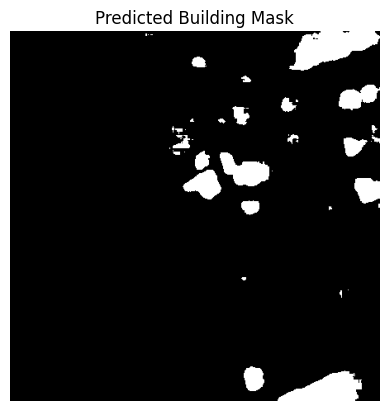

In [ ]:
plt.imshow(prediction, cmap='gray')
plt.title("Predicted Building Mask")
plt.axis("off")
plt.show()

In [ ]:
mask_to_save = (prediction * 255).astype(np.uint8)

In [ ]:
import rasterio

with rasterio.open(image_path) as src:
    meta = src.meta.copy()

meta.update({
    "count": 1,
    "dtype": "uint8"
})

with rasterio.open("predicted_mask.tif", "w", **meta) as dst:
    dst.write(mask_to_save, 1)

In [ ]:
from google.colab import files


In [ ]:
files.download(checkpoint_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("building_segmentation_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>